# S&P 500 Analysis and Prediction 

#### Importing All of The Tools That i'll Need

In [1]:
import pandas as pd 
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Downloading and Exploring My Data 

In [2]:
#I'm using pandas to download my data into the notebook
stock_df = pd.read_csv('^GSPC1980_2020.csv',date_parser = True )

In [7]:
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-01-02,107.940002,108.430000,105.290001,105.760002,105.760002,40610000
1,1980-01-03,105.760002,106.080002,103.260002,105.220001,105.220001,50480000
2,1980-01-04,105.220001,107.080002,105.089996,106.519997,106.519997,39130000
3,1980-01-07,106.519997,107.800003,105.800003,106.809998,106.809998,44500000
4,1980-01-08,106.809998,109.290001,106.290001,108.949997,108.949997,53390000


In [3]:
stock_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10082,2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,3223.379883,1296540000
10083,2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,3239.909912,2160680000
10084,2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,2428670000
10085,2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039,3221.290039,3013290000
10086,2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029,3230.780029,2893810000


In [8]:
stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10087.000000,10087.000000,10087.000000,10087.000000,10087.000000,1.008700e+04
mean,998.830845,1004.571136,992.714297,999.058833,999.058833,1.666173e+09
std,744.498951,747.729578,740.940145,744.572446,744.572446,1.768667e+09
min,98.220001,99.580002,94.230003,98.220001,98.220001,1.499000e+07
25%,330.369995,332.279999,328.419998,330.369995,330.369995,1.723000e+08
50%,987.760010,996.679993,977.489990,987.760010,987.760010,8.803000e+08
75%,1369.025024,1379.570007,1360.559998,1369.205017,1369.205017,3.215970e+09
max,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,1.145623e+10


In [9]:
type(stock_df['Date'][2])

str

In [10]:
#Set the format of the date in the date column to datetime 
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
#Put the date column as your index to avoid having to drop the column later on
stock_df = stock_df.set_index(['Date'])


In [113]:
d = stock_df.resample('M').mean()
roll_mean = d['Open'].rolling(3).mean()
roll_std = d['Open'].rolling(3).std()

In [115]:
d.shape[0]

480

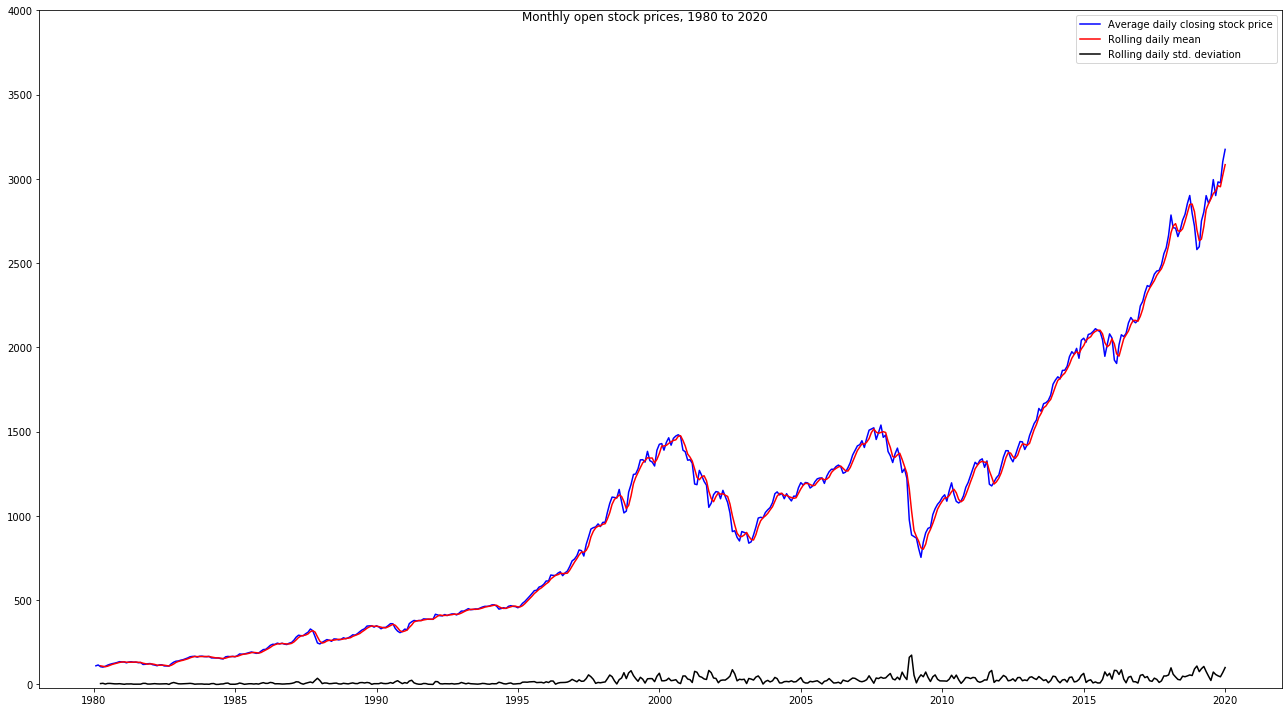

In [119]:
#I resampled my data to Average price by month for a more meaningful graph 


fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(d['Open'], color='blue',label='Average daily closing stock price')
ax.plot(roll_mean, color='red', label='Rolling daily mean')
ax.plot(roll_std, color='black', label='Rolling daily std. deviation')

ax.set_ylim(-20, 4000)
ax.legend()
fig.suptitle('Monthly open stock prices, 1980 to 2020')
fig.tight_layout()

In [120]:
New = d['2019-12']['Open'].reset_index(drop=True)
Old = d['1980-01']['Open'].reset_index(drop=True)

In [121]:
(New - Old)/Old

0    27.71321
Name: Open, dtype: float64

Looking at my data we can see that the S&P 500 has increased by 27% in the last 40 years. I want to point out two peaks and drops of the S&P 500. The First Being from 2000-2003 and the second from 2008-2010. Both time periods display our economy peaking and then going into a recession period followed by a period of economic growth. After the United States' last recession in 2008, we have seen 10 years of fairly constant growth. 


In [153]:
df = stock_df.resample('D').mean()
df.fillna(method='ffill',inplace=True)

In [154]:
# df['2000-01-02']
# df['2015-12-27']

In [155]:
# train = df['2000-01-02':'2015-12-31'].copy()
# train

In [439]:
training = df['2016-01-04':'2018-12-31'].copy()
training.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4.304880e+09
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3.706620e+09
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4.336660e+09
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5.076590e+09
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4.664940e+09


In [440]:
testing = df['2019-01-01':].copy()
testing.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,2498.939941,2509.239990,2482.820068,2506.850098,2506.850098,3.442870e+09
2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3.733160e+09
2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3.822860e+09
2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4.213410e+09
2019-01-05,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4.213410e+09


In [441]:
train = training.drop(['Adj Close'],axis = 1)

In [159]:
# Stocks_Daily_Close = stock_daily_df.drop(columns=['Open','High','Low','Adj Close','Volume',]

In [160]:
# training = stock_daily_df['2016-01-04':'2018-12-31']
# train_X,train_y = training[['Open','High','Low','Adj Close','Volume','Close']],training['Close']
# testing  = stock_daily_df['2019-01-01':]
# test_X,test_Y = testing[['Open','High','Low','Adj Close','Volume','Close']],testing['Close']

In [442]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train

array([[0.18561479, 0.17478583, 0.16076853, 0.16663799, 0.47211877],
       [0.16348246, 0.15992171, 0.17374065, 0.17031416, 0.37653833],
       [0.16160631, 0.15056995, 0.15125205, 0.1463052 , 0.47719608],
       ...,
       [0.60303981, 0.61547118, 0.5933607 , 0.59605872, 0.37589927],
       [0.60303981, 0.61547118, 0.5933607 , 0.59605872, 0.37589927],
       [0.60319381, 0.60538805, 0.60225066, 0.61522063, 0.33440056]])

In [443]:
X_train = []
y_train = []

In [444]:
train.shape[0]

1093

In [445]:
for i in range(60,train.shape[0]):
    X_train.append(train[i-60:i])
    y_train.append(train[i,0])

In [446]:
X_train,y_train = np.array(X_train), np.array(y_train)

In [447]:
X_train.shape, y_train.shape

((1033, 60, 5), (1033,))

Preping Test Data 

In [456]:
past_60_days = training.tail(60)

In [457]:
dff = past_60_days.append(testing)
dff = dff.drop(['Adj Close'],axis = 1)
dff.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-11-02,2745.449951,2756.550049,2700.439941,2723.060059,4.237930e+09
2018-11-03,2745.449951,2756.550049,2700.439941,2723.060059,4.237930e+09
2018-11-04,2745.449951,2756.550049,2700.439941,2723.060059,4.237930e+09
2018-11-05,2726.370117,2744.270020,2717.939941,2738.310059,3.623320e+09
2018-11-06,2738.399902,2756.820068,2737.080078,2755.449951,3.510860e+09


In [458]:
inputs =scaler.transform(dff)
inputs

array([[0.82661139, 0.83146705, 0.79707421, 0.81147718, 0.46142257],
       [0.82661139, 0.83146705, 0.79707421, 0.81147718, 0.46142257],
       [0.82661139, 0.83146705, 0.79707421, 0.81147718, 0.46142257],
       ...,
       [1.28138592, 1.28066298, 1.27507361, 1.28072836, 0.17236785],
       [1.27491488, 1.27425477, 1.25913817, 1.26372691, 0.26576911],
       [1.25233824, 1.26584461, 1.25507371, 1.2723411 , 0.2466805 ]])

In [459]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i,0])

In [460]:
X_test, y_test = np.array(X_test), np.array(y_test)

### Building RNN LSTM Model 

Base Model

In [172]:
model1 = Sequential()

model1.add(LSTM(units = 60, activation='relu', input_shape=(X_train.shape[1],5)))

model1.add(Dense(1))

In [173]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 60)                15840     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 15,901
Trainable params: 15,901
Non-trainable params: 0
_________________________________________________________________


In [174]:
model1.compile(optimizer='adam', loss = 'mean_squared_error')

In [175]:
model1.fit(X_train,y_train,epochs=10,batch_size=200)

Epoch 1/10
1033/1033 [==============================] - 1s 538us/step - loss: 0.3237
Epoch 2/10
1033/1033 [==============================] - 0s 264us/step - loss: 0.1175
Epoch 3/10
1033/1033 [==============================] - 0s 275us/step - loss: 0.0219
Epoch 4/10
1033/1033 [==============================] - 0s 276us/step - loss: 0.0038
Epoch 5/10
1033/1033 [==============================] - 0s 280us/step - loss: 0.0073
Epoch 6/10
1033/1033 [==============================] - 0s 289us/step - loss: 0.0030
Epoch 7/10
1033/1033 [==============================] - 0s 294us/step - loss: 0.0019
Epoch 8/10
1033/1033 [==============================] - 0s 287us/step - loss: 0.0014
Epoch 9/10
1033/1033 [==============================] - 0s 283us/step - loss: 0.0012
Epoch 10/10
1033/1033 [==============================] - 0s 282us/step - loss: 0.0011


In [461]:
y_pred1 = model1.predict(X_test)

In [462]:
y_pred1

array([[0.56460804],
       [0.5653755 ],
       [0.5658277 ],
       [0.5650948 ],
       [0.5673068 ],
       [0.5693828 ],
       [0.5714016 ],
       [0.5780173 ],
       [0.586682  ],
       [0.59643537],
       [0.6040405 ],
       [0.61148924],
       [0.6182889 ],
       [0.6242893 ],
       [0.62929475],
       [0.6348701 ],
       [0.6430273 ],
       [0.65031695],
       [0.6613556 ],
       [0.6714757 ],
       [0.68050784],
       [0.6884537 ],
       [0.69345576],
       [0.6955091 ],
       [0.6977211 ],
       [0.70308423],
       [0.7077861 ],
       [0.71197426],
       [0.71243554],
       [0.7129713 ],
       [0.71630144],
       [0.72442734],
       [0.7307674 ],
       [0.736937  ],
       [0.74238634],
       [0.7467695 ],
       [0.75357234],
       [0.75974864],
       [0.76386195],
       [0.76459146],
       [0.7651253 ],
       [0.76538694],
       [0.76679826],
       [0.7714666 ],
       [0.777799  ],
       [0.78305477],
       [0.7896729 ],
       [0.795

In [180]:
scale = 1/9.06322517e-04
scale

1103.3599863656482

In [463]:
y_test = y_test*scale
y_pred1= y_pred1*scale

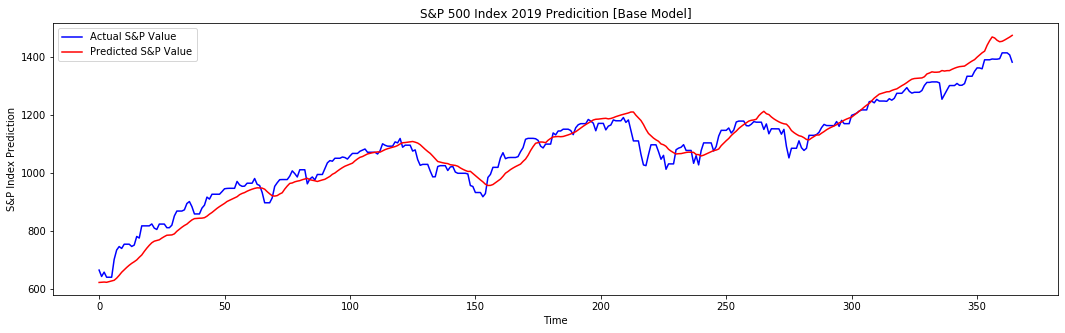

In [464]:
plt.figure(figsize=(18,5))
plt.plot(y_test, color = 'b', label = 'Actual S&P Value')
plt.plot(y_pred1 ,color ='r', label = 'Predicted S&P Value')
plt.title('S&P 500 Index 2019 Predicition [Base Model]')
plt.xlabel('Time')
plt.ylabel('S&P Index Prediction')
plt.legend()
plt.show()

In [465]:
from math import sqrt

In [466]:
rmse = sqrt(mean_squared_error(y_test, y_pred1))

In [467]:
rmse

42.360872284959775

Model 2 

In [476]:
model2 = Sequential()

model2.add(LSTM(units = 110, activation='relu', input_shape=(X_train.shape[1],5)))

model2.add(Dense(1))



In [477]:
model2.summary()



Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 110)               51040     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 111       
Total params: 51,151
Trainable params: 51,151
Non-trainable params: 0
_________________________________________________________________


In [478]:
model2.compile(optimizer='adam', loss = 'mean_squared_error')

model2.fit(X_train,y_train,epochs=80,batch_size=50)

Epoch 1/80
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0522
Epoch 2/80
1033/1033 [==============================] - 1s 660us/step - loss: 0.0024
Epoch 3/80
1033/1033 [==============================] - 1s 658us/step - loss: 5.4341e-04
Epoch 4/80
1033/1033 [==============================] - 1s 665us/step - loss: 4.5473e-04
Epoch 5/80
1033/1033 [==============================] - 1s 667us/step - loss: 4.2128e-04
Epoch 6/80
1033/1033 [==============================] - 1s 671us/step - loss: 3.9418e-04
Epoch 7/80
1033/1033 [==============================] - 1s 674us/step - loss: 3.6962e-04
Epoch 8/80
1033/1033 [==============================] - 1s 674us/step - loss: 3.7280e-04
Epoch 9/80
1033/1033 [==============================] - 1s 672us/step - loss: 4.4444e-04
Epoch 10/80
1033/1033 [==============================] - 1s 677us/step - loss: 4.2405e-04
Epoch 11/80
1033/1033 [==============================] - 1s 669us/step - loss: 3.2225e-04
Epoch 12/80
1033/1033 [======

In [479]:
y_pred2 = model2.predict(X_test)

y_pred2

array([[0.61787903],
       [0.61721045],
       [0.61324257],
       [0.5901846 ],
       [0.6041395 ],
       [0.6141668 ],
       [0.62016606],
       [0.63944954],
       [0.660295  ],
       [0.67623043],
       [0.68354917],
       [0.6885425 ],
       [0.689896  ],
       [0.6895927 ],
       [0.6837592 ],
       [0.69096863],
       [0.7031056 ],
       [0.7133041 ],
       [0.73737377],
       [0.74865794],
       [0.7529953 ],
       [0.7541757 ],
       [0.7386587 ],
       [0.72979194],
       [0.72970015],
       [0.74355775],
       [0.75024396],
       [0.75297064],
       [0.7410347 ],
       [0.7353161 ],
       [0.7492904 ],
       [0.77087975],
       [0.7842543 ],
       [0.79030937],
       [0.79212224],
       [0.7977708 ],
       [0.8100049 ],
       [0.81371456],
       [0.80050224],
       [0.79054433],
       [0.78721786],
       [0.78655565],
       [0.7920682 ],
       [0.80977684],
       [0.8262566 ],
       [0.82798654],
       [0.8419547 ],
       [0.848

In [480]:
y_pred2= y_pred2*scale

In [481]:
y_pred2


array([[ 681.743  ],
       [ 681.0053 ],
       [ 676.6273 ],
       [ 651.1861 ],
       [ 666.5834 ],
       [ 677.6471 ],
       [ 684.2664 ],
       [ 705.543  ],
       [ 728.5431 ],
       [ 746.1256 ],
       [ 754.2008 ],
       [ 759.7102 ],
       [ 761.2036 ],
       [ 760.869  ],
       [ 754.43256],
       [ 762.38715],
       [ 775.7786 ],
       [ 787.0312 ],
       [ 813.5887 ],
       [ 826.03925],
       [ 830.8249 ],
       [ 832.1273 ],
       [ 815.0065 ],
       [ 805.2232 ],
       [ 805.12195],
       [ 820.41187],
       [ 827.7892 ],
       [ 830.79767],
       [ 817.628  ],
       [ 811.31836],
       [ 826.73706],
       [ 850.55786],
       [ 865.3148 ],
       [ 871.9957 ],
       [ 873.996  ],
       [ 880.2284 ],
       [ 893.727  ],
       [ 897.82007],
       [ 883.2421 ],
       [ 872.255  ],
       [ 868.58466],
       [ 867.854  ],
       [ 873.93634],
       [ 893.47534],
       [ 911.65845],
       [ 913.5672 ],
       [ 928.9791 ],
       [ 936.

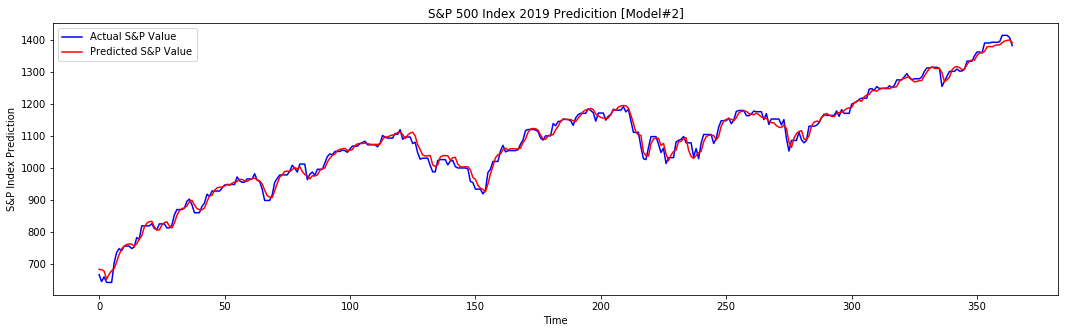

In [484]:

plt.figure(figsize=(18,5))
plt.plot(y_test, color = 'b', label = 'Actual S&P Value')
plt.plot(y_pred2 ,color ='r', label = 'Predicted S&P Value')
plt.title('S&P 500 Index 2019 Predicition [Model#2]')
plt.xlabel('Time')
plt.ylabel('S&P Index Prediction')
plt.legend()
plt.show()

In [483]:

rmse = sqrt(mean_squared_error(y_test, y_pred2))

rmse

13.950106577606284

Model 3 

In [490]:
model3 = Sequential()

model3.add(LSTM(units = 110, activation='relu',return_sequences = True, input_shape=(X_train.shape[1],5)))
model3.add(Dropout(0.2))

model3.add(LSTM(units = 80, activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(1))



In [491]:
model3.summary()



Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 60, 110)           51040     
_________________________________________________________________
dropout_44 (Dropout)         (None, 60, 110)           0         
_________________________________________________________________
lstm_79 (LSTM)               (None, 80)                61120     
_________________________________________________________________
dropout_45 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 81        
Total params: 112,241
Trainable params: 112,241
Non-trainable params: 0
_________________________________________________________________


In [492]:
model3.compile(optimizer='adam', loss = 'mean_squared_error')

model3.fit(X_train,y_train,epochs=50,batch_size=50)

Epoch 1/50
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0447
Epoch 2/50
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0075
Epoch 3/50
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0059
Epoch 4/50
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 5/50
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0047
Epoch 6/50
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0042
Epoch 7/50
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 8/50
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0043
Epoch 9/50
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0041
Epoch 10/50
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0036
Epoch 11/50
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0043
Epoch 12/50
1033/1033 [==============================] - 1s 1ms/step - loss: 0.0043
E

In [493]:
y_pred3 = model3.predict(X_test)

y_pred3

array([[0.5920582 ],
       [0.6000332 ],
       [0.60524166],
       [0.60435027],
       [0.6040438 ],
       [0.60383874],
       [0.60376763],
       [0.6073705 ],
       [0.61387694],
       [0.6223396 ],
       [0.63142526],
       [0.64067477],
       [0.6492702 ],
       [0.6568936 ],
       [0.66235244],
       [0.66802025],
       [0.6741377 ],
       [0.68074924],
       [0.68958795],
       [0.69882584],
       [0.7075511 ],
       [0.71515286],
       [0.71921897],
       [0.7224802 ],
       [0.72461414],
       [0.72733235],
       [0.7301042 ],
       [0.732723  ],
       [0.7328512 ],
       [0.7326826 ],
       [0.73413336],
       [0.7344097 ],
       [0.74039865],
       [0.7473995 ],
       [0.7544342 ],
       [0.7617671 ],
       [0.7698407 ],
       [0.77761275],
       [0.77968717],
       [0.7813483 ],
       [0.781896  ],
       [0.78179324],
       [0.78357506],
       [0.7869618 ],
       [0.79260284],
       [0.79757226],
       [0.8044734 ],
       [0.811

In [494]:
y_pred3= y_pred3*scale

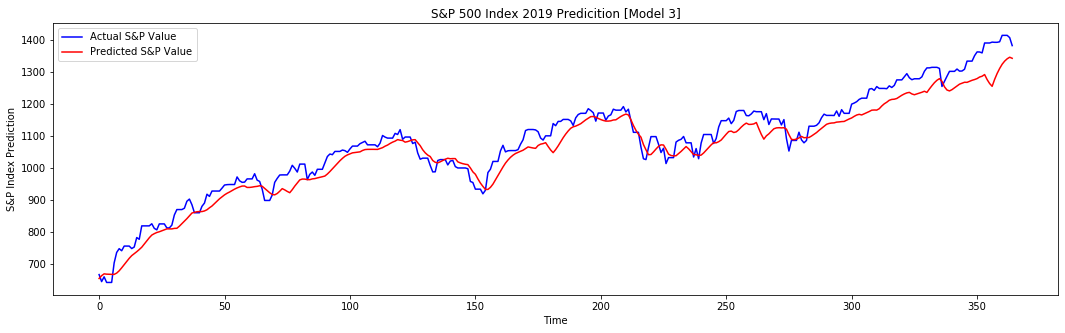

In [495]:

plt.figure(figsize=(18,5))
plt.plot(y_test, color = 'b', label = 'Actual S&P Value')
plt.plot(y_pred3 ,color ='r', label = 'Predicted S&P Value')
plt.title('S&P 500 Index 2019 Predicition [Model 3]')
plt.xlabel('Time')
plt.ylabel('S&P Index Prediction')
plt.legend()
plt.show()

In [496]:

rmse = sqrt(mean_squared_error(y_test, y_pred3))

rmse

41.46814046449838

#### Model4

In [534]:
regressor = Sequential()

regressor.add(LSTM(units = 150, activation='relu',return_sequences = True, input_shape=(X_train.shape[1],5)))
regressor.add(Dropout(0.15))

regressor.add(LSTM(units = 100, activation='relu',return_sequences = True))
regressor.add(Dropout(0.15))

regressor.add(LSTM(units = 80, activation='relu'))
regressor.add(Dropout(0.15))

regressor.add(Dense(1))

In [535]:
regressor.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_96 (LSTM)               (None, 60, 150)           93600     
_________________________________________________________________
dropout_61 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
lstm_97 (LSTM)               (None, 60, 100)           100400    
_________________________________________________________________
dropout_62 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_98 (LSTM)               (None, 80)                57920     
_________________________________________________________________
dropout_63 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)               

In [536]:
regressor.compile(optimizer='adam', loss = 'mean_squared_error')

In [537]:
regressor.fit(X_train,y_train,epochs=180,batch_size=50)

Epoch 1/180
1033/1033 [==============================] - 3s 3ms/step - loss: 0.1389
Epoch 2/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0246
Epoch 3/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0066
Epoch 4/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0047
Epoch 5/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0049
Epoch 6/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0046
Epoch 7/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0047
Epoch 8/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0046
Epoch 9/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0045
Epoch 10/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0044
Epoch 11/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0037
Epoch 12/180
1033/1033 [==============================] - 2s 2ms/step - lo

1033/1033 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 98/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0018
Epoch 99/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0018
Epoch 100/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0015
Epoch 101/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 102/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0018
Epoch 103/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 104/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0017
Epoch 105/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 106/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0017
Epoch 107/180
1033/1033 [==============================] - 2s 2ms/step - loss: 0.0021
Epoch 108/180
1033/1033 [==============================] - 2s 2ms/step

In [529]:
y_pred4 = regressor.predict(X_test)

In [530]:
y_pred4

array([[0.59260845],
       [0.5996199 ],
       [0.6017276 ],
       [0.5913358 ],
       [0.5846235 ],
       [0.5825355 ],
       [0.583442  ],
       [0.5876856 ],
       [0.5950167 ],
       [0.604576  ],
       [0.6143698 ],
       [0.6230384 ],
       [0.6302389 ],
       [0.6359527 ],
       [0.6399139 ],
       [0.6434182 ],
       [0.6478498 ],
       [0.6532124 ],
       [0.6609254 ],
       [0.67006826],
       [0.67938375],
       [0.6879407 ],
       [0.6926476 ],
       [0.6937195 ],
       [0.69284415],
       [0.6932049 ],
       [0.69502544],
       [0.6976873 ],
       [0.698223  ],
       [0.6969285 ],
       [0.69770074],
       [0.7029766 ],
       [0.7101897 ],
       [0.7179791 ],
       [0.72535014],
       [0.73157   ],
       [0.7377573 ],
       [0.7435836 ],
       [0.7463276 ],
       [0.74623096],
       [0.74456227],
       [0.74254006],
       [0.7419082 ],
       [0.7447499 ],
       [0.75060236],
       [0.7575127 ],
       [0.76556414],
       [0.773

In [531]:
y_pred4 = y_pred4*scale
y_pred4

array([[ 653.8605 ],
       [ 661.5966 ],
       [ 663.9222 ],
       [ 652.45624],
       [ 645.0502 ],
       [ 642.74634],
       [ 643.7465 ],
       [ 648.4288 ],
       [ 656.51764],
       [ 667.06494],
       [ 677.8711 ],
       [ 687.43567],
       [ 695.3804 ],
       [ 701.68475],
       [ 706.0554 ],
       [ 709.9219 ],
       [ 714.8115 ],
       [ 720.72845],
       [ 729.23865],
       [ 739.32654],
       [ 749.60486],
       [ 759.04626],
       [ 764.2396 ],
       [ 765.42236],
       [ 764.45654],
       [ 764.85455],
       [ 766.8633 ],
       [ 769.8003 ],
       [ 770.3913 ],
       [ 768.963  ],
       [ 769.81506],
       [ 775.6362 ],
       [ 783.5949 ],
       [ 792.1894 ],
       [ 800.3223 ],
       [ 807.18506],
       [ 814.0119 ],
       [ 820.4404 ],
       [ 823.46796],
       [ 823.3614 ],
       [ 821.5202 ],
       [ 819.289  ],
       [ 818.5918 ],
       [ 821.72723],
       [ 828.18463],
       [ 835.8092 ],
       [ 844.6929 ],
       [ 853.

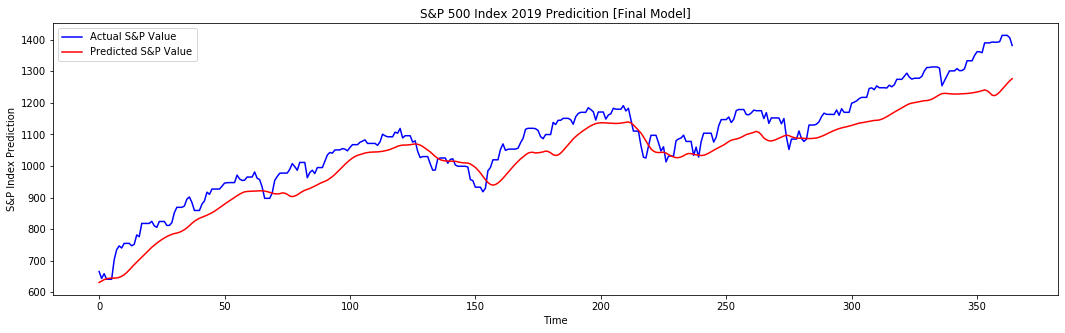

In [532]:
plt.figure(figsize=(18,5))
plt.plot(y_test, color = 'b', label = 'Actual S&P Value')
plt.plot(y_pred ,color ='r', label = 'Predicted S&P Value')
plt.title('S&P 500 Index 2019 Predicition [Final Model]')
plt.xlabel('Time')
plt.ylabel('S&P Index Prediction')
plt.legend()
plt.show()

In [533]:
rmse = sqrt(mean_squared_error(y_test, y_pred4))

rmse

93.73697622083414